In [70]:
from utils.helper_functions import load_model, prepare_data_features
from models.simclr_model import SimCLR
from models.simclr_transformer import SimCLR_Transformer
from datasets.datamodules import EEGdataModule
from sklearn.manifold import TSNE
from datasets.datasets import SHHS_dataset_STFT
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from utils.helper_functions import get_data_path
import torch
import torch.utils.data as data
import experiments.SleepTransformer.simclr.train as tt
import constants

In [71]:
encoder_path = "no_recon_100epochs.ckpt"
pretrained_model = load_model(SimCLR_Transformer, encoder_path)

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'aug_module' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['aug_module'])`.
  rank_zero_warn(
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'cont_projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['cont_projector'])`.
  rank_zero_warn(


In [72]:
encoder = pretrained_model.f
test_dm = EEGdataModule(
    data_path=get_data_path(),
    batch_size=64,
    data_split=[4, 1],
    dataset_type=SHHS_dataset_STFT,
    test_set=True,
    num_patients=10,  # shouldn't matter
    num_workers=0,
    exclude_test_set=tuple(torch.randint(0,100,(10,)))
)

Size of patients: 10
Couldn't find file at path:  C:/Users/tomsm/PycharmProjects/thesis02/data/n0014_eeg.mat
Couldn't find file at path:  C:/Users/tomsm/PycharmProjects/thesis02/data/n0000_eeg.mat
Couldn't find file at path:  C:/Users/tomsm/PycharmProjects/thesis02/data/n0094_eeg.mat
Couldn't find file at path:  C:/Users/tomsm/PycharmProjects/thesis02/data/n0014_eeg.mat


In [73]:
outputs = list()
labels = list()
with torch.no_grad():
    for batch in test_dm.test_dataloader():
        outputs.append(encoder(batch[0]))
        labels.append(batch[1])

outputs = torch.cat(outputs, dim=0)
labels = torch.cat(labels, dim=0)
output_ds = data.TensorDataset(outputs, labels.squeeze())

C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tomsm\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5952 samples in 0.000s...
[t-SNE] Computed neighbors for 5952 samples in 0.799s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5952
[t-SNE] Computed conditional probabilities for sample 2000 / 5952
[t-SNE] Computed conditional probabilities for sample 3000 / 5952
[t-SNE] Computed conditional probabilities for sample 4000 / 5952
[t-SNE] Computed conditional probabilities for sample 5000 / 5952
[t-SNE] Computed conditional probabilities for sample 5952 / 5952
[t-SNE] Mean sigma: 26.516767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.336662
[t-SNE] KL divergence after 300 iterations: 3.418726


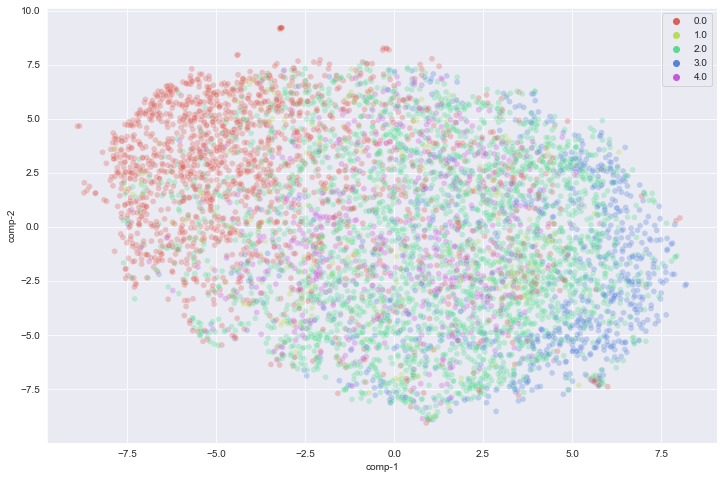

In [74]:
tsne = TSNE(n_components=2, n_iter=300, verbose=1, perplexity=30)
x, y = outputs, labels.squeeze()
x.requires_grad = False
y.requires_grad = False
tsne_results = tsne.fit_transform(x)
df = pd.DataFrame()
df['comp-1'] = tsne_results[:,0]
df['comp-2'] = tsne_results[:,1]
df["y"] = y
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)
save_name = 'tsne_'+encoder_path.split('.ckpt')[0]
plt.savefig(save_name+'1')

# Let's try zero shot classification with kNN on the feature space as a heuristic

In [75]:
from sklearn.neighbors import KNeighborsClassifier

In [76]:
knn_dm = EEGdataModule(
    data_path=get_data_path(),
    batch_size=64,
    data_split=[4, 1],
    dataset_type=SHHS_dataset_STFT,
    test_set=True,
    num_patients=10,  # shouldn't matter
    num_workers=0,
    exclude_test_set=(8,)
)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(outputs, labels.squeeze())

Size of patients: 1


KNeighborsClassifier()

In [77]:
test_outputs = list()
test_labels = list()
with torch.no_grad():
    for batch in knn_dm.test_dataloader():
        test_outputs.append(encoder(batch[0]))
        test_labels.append(batch[1])
test_outputs = torch.cat(test_outputs, dim=0)
test_labels = torch.cat(test_labels, dim=0)

In [78]:
accuracy = knn.score(test_outputs, test_labels)
print(accuracy)

0.4185267857142857
